### Import Libraries used

In [119]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform
from scipy import ndimage
import skimage.color
import skimage.io
from cv2 import KeyPoint
from numpy import arctan2, logical_and, roll, sqrt, rad2deg, where, zeros, round
import math
from tabulate import tabulate

### Input Images

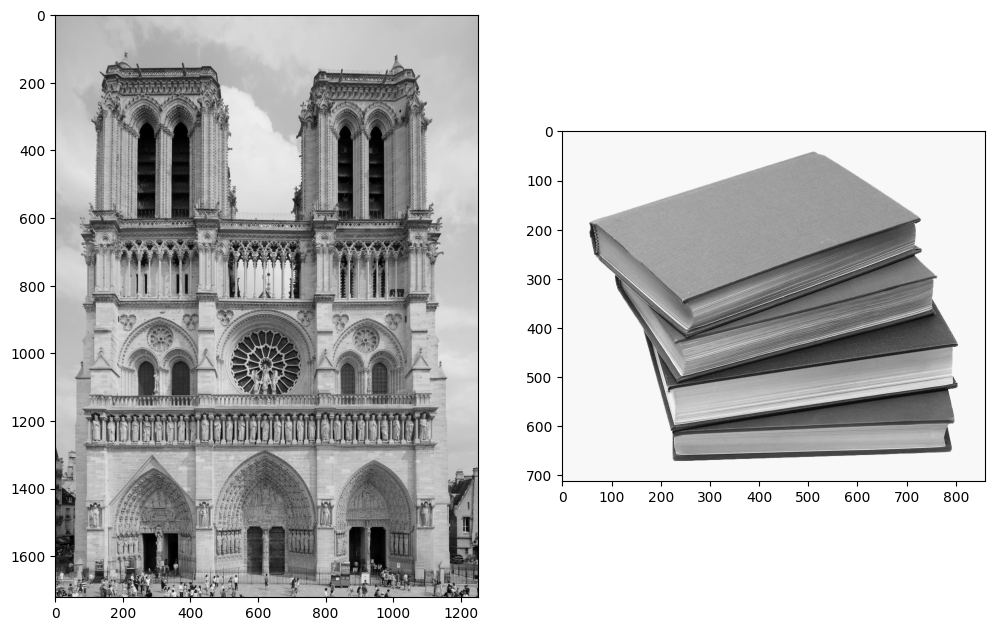

In [120]:
books = skimage.color.rgb2gray(skimage.io.imread('img1.png')[:,:,:3])
building = skimage.color.rgb2gray(skimage.io.imread('img2.png')[:,:,:3])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(books,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(building,cmap='gray')
plt.show()

### STEP 1: Scale Space Extrema Detection

In [121]:
def extrema_detection(k, lower_layer, layer, upper_layer, x, y):
    '''Evaluates whether a pixel is extrema or not'''

    extrema_points = np.zeros([x, y])
    key_pts = []

    for i in range(1, x - 1):
        for j in range(1, y - 1):
            middle = layer[i,j]
            matrix = layer[i-1 : i+2, j-1 : j+2]
            matrix_upper = upper_layer[i-1 : i+2, j-1 : j+2]
            matrix_lower = lower_layer[i-1 : i+2, j-1 : j+2]
            matrix[1,1] = -1
            if(np.max(matrix)<middle):
                if(middle>max(np.max(matrix_upper),np.max(matrix_lower))):
                    extrema_points[i,j] = 1
                    key_pts.append([i,j,k])

            else:
                matrix[1,1] = 256
                if(np.min(matrix)>middle):
                    if(middle<min(np.min(matrix_upper),np.min(matrix_lower))):
                        extrema_points[i,j] = 1
                        key_pts.append([i,j,k])

            
    return key_pts

In [122]:
def scale_space_extrema_detection(image):
    '''Computes DOG and adds all the keypoints to a list'''
    
    sigma = 1.5
    s = 10  
    k = 2**((s-1)**(-1)) 
    key_pts_all = []
    
    Discrete_Gaussian_Scale_Space_ = [None] * s
    for i in range(s):
        Discrete_Gaussian_Scale_Space_[i] = ndimage.gaussian_filter(image, sigma * (k ** i)) * 255

    Difference_of_gaussians = [None] * (s - 1)
    for i in range(s - 1):
        Difference_of_gaussians[i] = Discrete_Gaussian_Scale_Space_[i + 1] - Discrete_Gaussian_Scale_Space_[i]

    for i in range(s - 3):
        #print(i)
        key_pts = extrema_detection(((k*sigma)**i), Difference_of_gaussians[i].copy(), Difference_of_gaussians[i+1].copy(), Difference_of_gaussians[i + 2].copy(), image.shape[0],image.shape[1])
        key_pts_all.append(key_pts)
    
    key_pts_all_flatten = [j for sub in key_pts_all for j in sub]

    
    return key_pts_all_flatten, len(key_pts_all_flatten)


### Step 3: Orientation detection

In [123]:
def compute_Keypoint_Orientations(gaussian_image, row, col, size):
    """Compute orientations for each keypoint
    """
    image_shape = gaussian_image.shape

    radius_factor=3
    num_bins=36
    peak_ratio=0.8
    float_tolerance = 1e-7
    orientation = 0
    
    scale = size
    radius = int(round(radius_factor * scale))
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(max(col - radius+1,0), min(col + radius + 1,image_shape[0]-1)):
        for j in range(max(row - radius+1,0), min(row + radius + 1,image_shape[1]-1)):
            distance = math.sqrt((i - col)**2 + (row - j)**2)
            if distance <= radius:
                dx = gaussian_image[i, j + 1] - gaussian_image[i, j - 1]
                dy = gaussian_image[i - 1, j] - gaussian_image[i + 1, j]
                gradient_magnitude = sqrt(dx * dx + dy * dy)
                gradient_orientation = rad2deg(arctan2(dy, dx))
                weight = gradient_magnitude  # constant in front of exponential can be dropped because we will find peaks later
                histogram_index = int(round(gradient_orientation * num_bins / 360.))
                raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude


    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            
    return orientation


In [124]:
books_original, no_keypt_books = scale_space_extrema_detection(books)
building_original, no_keypt_building = scale_space_extrema_detection(building)

In [125]:
def obtain_keypts(img, keypt):
    '''Creates KeyPoint obect for each keypoint'''
    keypoints = []
    for item in keypt:
        if not item[2]:
            continue
        temp = compute_Keypoint_Orientations(img, item[0], item[1], item[2])
        keypoint = KeyPoint()
        keypoint.pt = item[1], item[0]
        keypoint.size = item[2]
        keypoint.angle = temp
        keypoints.append(keypoint)
    return keypoints

def plotkeypoints(image, keypoints):
    '''Plots the keypoints on the image'''
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    converted_books = cv2.convertScaleAbs(normalized_image)
    plt.imshow(converted_books,cmap='gray')
    output_image = cv2.drawKeypoints(converted_books,keypoints, 0, (255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(output_image,cmap='gray')



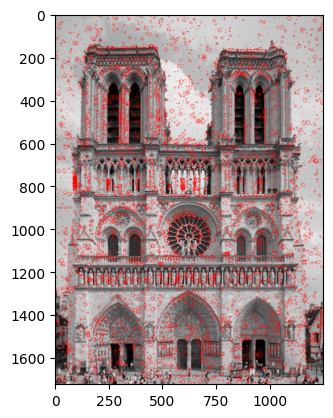

In [126]:
import cv2
book_keypoints = obtain_keypts(books, books_original)
plotkeypoints(books, book_keypoints)

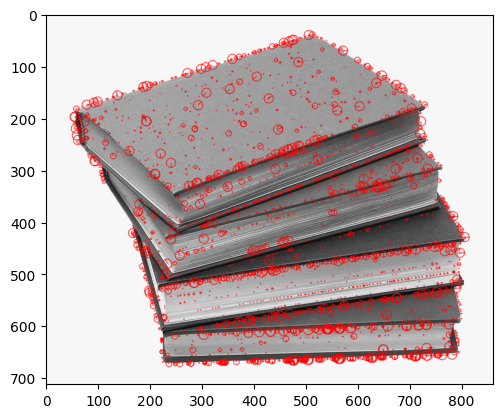

In [127]:
building_keypoints = obtain_keypts(building, building_original)
plotkeypoints(building, building_keypoints)

### Step 4: PCA Descriptor

In [128]:
def extract_and_normalize_patch(image, keypoint, patch_size=41):
    '''Extracts 41*41 patch around the keypoint according to scale and orientation'''

    half_patch_size = patch_size // 2
    x, y = keypoint.pt
    orientation = keypoint.angle
    scale = keypoint.size
    gradient = []

    # Ensure the patch is within the image boundaries
    patch_x_start = int(max(0, x - half_patch_size))
    patch_x_end = int(min(image.shape[1], x + half_patch_size + 1))
    patch_y_start = int(max(0, y - half_patch_size))
    patch_y_end = int(min(image.shape[0], y + half_patch_size + 1))

    # Extract the patch
    patch = image[patch_y_start:patch_y_end, patch_x_start:patch_x_end]
    patch_resized = cv2.resize(patch, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    final_patch = patch_resized[:41, :41]
    rows, cols = final_patch.shape

    # Rotate the patch to the canonical direction
    rotation_angle = -orientation * (180 / np.pi)
    rotated_patch = cv2.warpAffine(patch, cv2.getRotationMatrix2D((half_patch_size, half_patch_size), rotation_angle, 1.0), (patch_size, patch_size))

    # Compute gradient magnitude and orientation
    for i in range(1, rotated_patch.shape[0] - 1):
        for j in range(1, rotated_patch.shape[1] - 1):
            gradient.append(rotated_patch[i, j + 1] - rotated_patch[i, j - 1])
            gradient.append(rotated_patch[i + 1, j] - rotated_patch[i - 1, j])


    #print(len(gradient))
    return gradient

def pca(data):
    '''convert 3042 dimensional data to 20 dimensions'''

    n, dimension = len(data), len(data[0])
    X = data

    # 1. Center the data
    mean = np.mean(X, axis=0)
    centered_data = X - mean

    # 2. Compute the covariance matrix
    covariance_matrix = np.matmul(data.T,data)

    # 3. Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # 4. Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # 5. Choose the top 20 eigenvectors to form the transformation matrix
    n_components = 20
    transformation_matrix = eigenvectors[:, :n_components]

    # 6. Project the centered data onto the new subspace
    reduced_data = np.dot(centered_data, transformation_matrix)

    print("Original Shape:", X.shape)
    print("Reduced Shape:", reduced_data.shape)
    return reduced_data


In [129]:
data_books = []
numpy_img_books = books.astype('float32')

#for simplicity I have taken only 5 keypoints of book image to lower down the execution time
for keypoint in book_keypoints[:5]:
    vector = extract_and_normalize_patch(numpy_img_books, keypoint, patch_size=41)
    data_books.append(vector)

data_np_books = np.array(data_books)
pca_vector_books = pca(data_np_books)

#print(pca_vector_books)
print("Descriptors for books image:")
pca_table_books = tabulate(pca_vector_books, tablefmt="pretty", numalign="center")
print(pca_table_books)

Original Shape: (5, 3042)
Reduced Shape: (5, 20)
Descriptors for books image:
+------------------------+---------------------+---------------------+---------------------+-----------------------+-------------------------+-------------------------+-------------------------+------------------------+------------------------+------------------------+-------------------------+-------------------------+------------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|   2.4133334159851074   | -4.817544937133789  |  5.144326210021973  | 2.9877214431762695  |  1.2088547945022583   |  5.21540641784668e-08   | -4.470348358154297e-08  | 2.9802322387695312e-08  | 1.1920928955078125e-07 | 3.725290298461914e-08  | -7.450580596923828e-09 |  9.313225746154785e-08  | 2.2351741790771484e-08  | 8.940696716308594e-08  | -7.82310962677002e-08  | 4.470348358154297e-08  |  6.705522537231445e-08  

In [130]:
data_building = []
numpy_img_building = building.astype('float32')

#for simplicity I have taken only 5 keypoints of book image to lower down the execution time
for keypoint in building_keypoints[:5]:
    vector = extract_and_normalize_patch(numpy_img_building, keypoint, patch_size=41)
    data_building.append(vector)

data_np_building = np.array(data_building)
pca_vector_building = pca(data_np_building)

#print(pca_vector_books)
print("Descriptors for building image:")
pca_table_building = tabulate(pca_vector_building, tablefmt="pretty", numalign="center")
print(pca_table_building)

Original Shape: (5, 3042)
Reduced Shape: (5, 20)
Descriptors for building image:
+---------------------+--------------------+----------------------+-----------------------+-------------------------+------------------------+-------------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| -0.1002931222319603 | 0.6196796298027039 |  2.004352569580078   | 0.009399858303368092  |  -0.032020099461078644  | 1.1874362826347351e-08 | -4.1443854570388794e-08 | 2.2351741790771484e-08 | -2.223532646894455e-08 | -1.4435499906539917e-08 |  3.748573362827301e-08  | -4.6566128730773926e-09 | 1.4435499906539917e-08  | -2.2177118808031082e-08 |  1.658918336033821e-08  | -2.561137080192566e-08  | 2.16532498598

### SIFT on Transformed Images

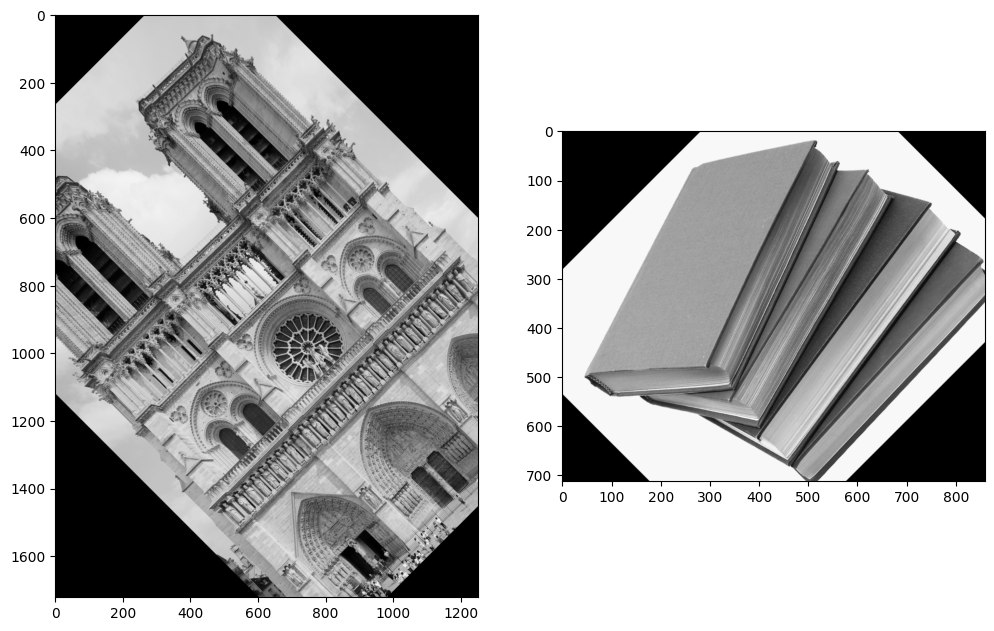

In [131]:
books_rotated = skimage.transform.rotate(books, 45)
building_rotated = skimage.transform.rotate(building, 45)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(books_rotated,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(building_rotated,cmap='gray')
plt.show()

In [132]:
books_rotated_keypt, no_keypt_books_rotated = scale_space_extrema_detection(books_rotated)
building_rotated_keypt, no_keypt_building_rotated = scale_space_extrema_detection(building_rotated)

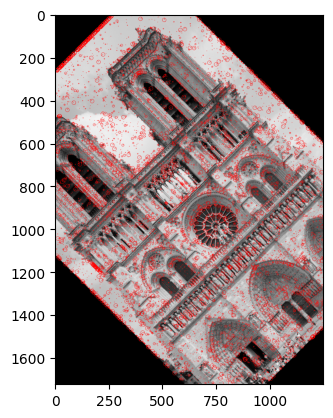

In [134]:
rotated_book_keypoints = obtain_keypts(books_rotated, books_rotated_keypt)
plotkeypoints(books_rotated, rotated_book_keypoints)

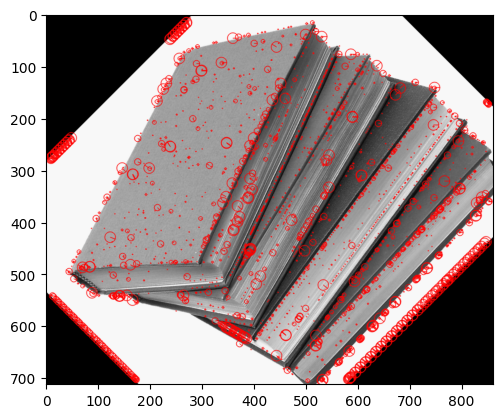

In [ ]:
rotated_building_keypoints = obtain_keypts(building_rotated, building_rotated_keypt)
plotkeypoints(building_rotated, rotated_building_keypoints)

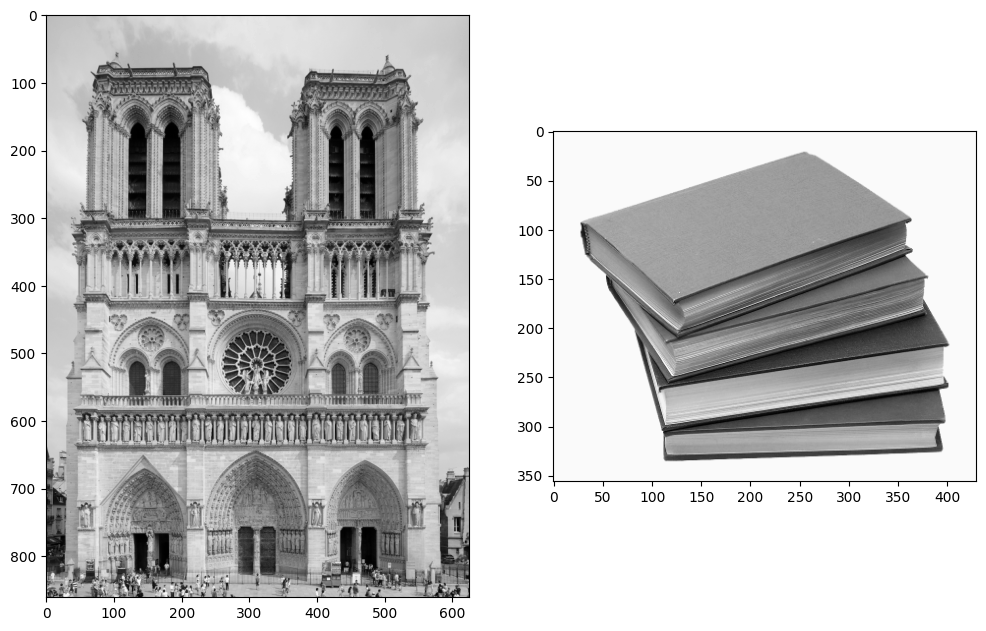

In [ ]:
books_downscale = skimage.transform.rescale(books, 0.5, anti_aliasing=False)
building_downscale = skimage.transform.rescale(building, 0.5, anti_aliasing=False)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(books_downscale,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(building_downscale,cmap='gray')
plt.show()

In [135]:
books_downscale_SIFT, n1 = scale_space_extrema_detection(books_downscale)
building_downscale_SIFT, n2 = scale_space_extrema_detection(building_downscale)

'rotated_book_keypoints = obtain_keypts(books_rotated, books_rotated)\nplotkeypoints(books_rotated, rotated_book_keypoints)'

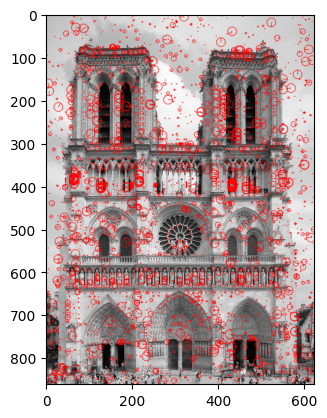

In [ ]:
downscale_book_keypoints= obtain_keypts(books_downscale, books_downscale_SIFT)
plotkeypoints(books_downscale, downscale_book_keypoints)

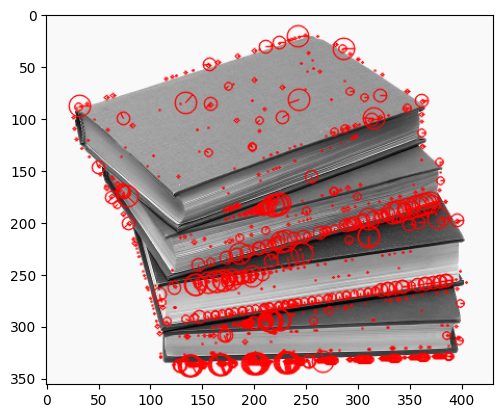

In [ ]:
downscale_building_keypoints = obtain_keypts(building_downscale, building_downscale_SIFT)
plotkeypoints(building_downscale, downscale_building_keypoints)

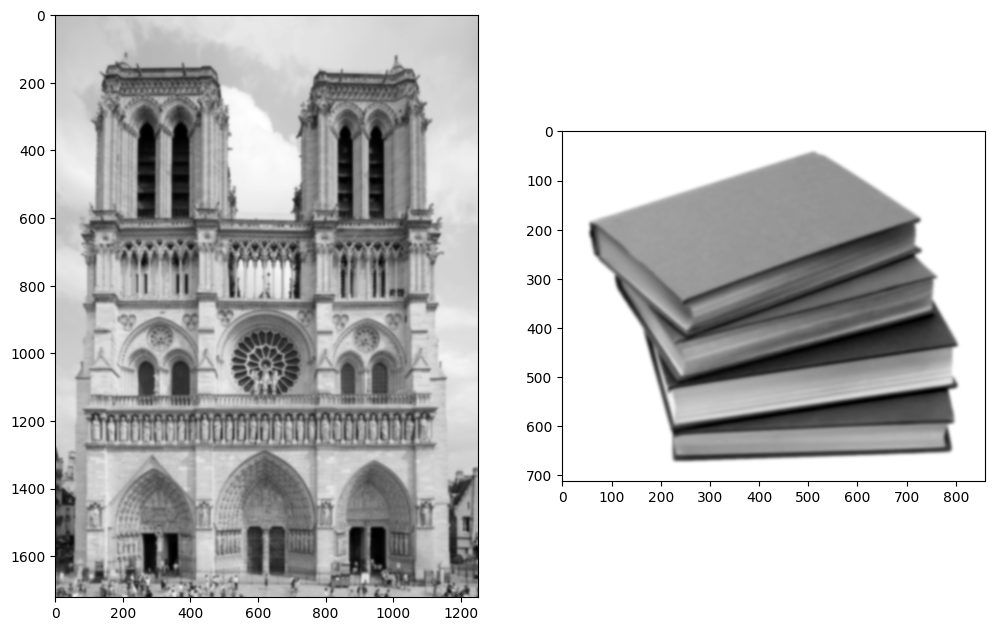

In [ ]:
books_gaussianblur = ndimage.gaussian_filter(books, 3)
building_gaussianblur = ndimage.gaussian_filter(building, 3)
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(books_gaussianblur,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(building_gaussianblur,cmap='gray')
plt.show()

In [136]:
books_gaussianblur_SIFT, n3 = scale_space_extrema_detection(books_gaussianblur)
building_dgaussianblur_SIFT, n4 = scale_space_extrema_detection(building_gaussianblur)

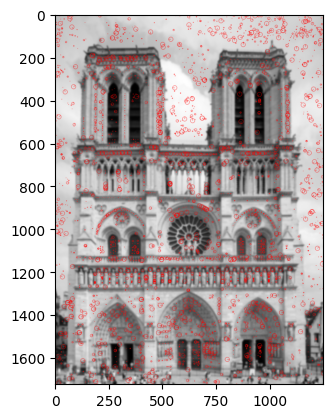

In [ ]:
gaussianblur_book_keypoints = obtain_keypts(books_gaussianblur, books_gaussianblur_SIFT)
plotkeypoints(books_gaussianblur, gaussianblur_book_keypoints)

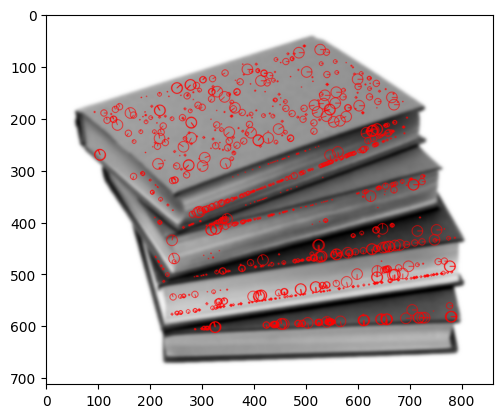

In [ ]:
gaussianblur_building_keypoints = obtain_keypts(building_gaussianblur, building_dgaussianblur_SIFT)
plotkeypoints(building_gaussianblur, gaussianblur_building_keypoints)

### Quantitative Analysis

In [ ]:
data = [
    ['Original', no_keypt_books, no_keypt_building],
    ['Rotation(45)', no_keypt_books_rotated, no_keypt_building_rotated],
    ['Downscale(x0.5)', n1, n2],
    ["Gaussian Blur(sigma = 3)", n3, n4]
]

headers = ["Type", "No of key_pt in image1", "No of key_pt in image2"]

table = tabulate(data, headers=headers, tablefmt="pretty", numalign="center")

print(table)

+--------------------------+------------------------+------------------------+
|           Type           | No of key_pt in image1 | No of key_pt in image2 |
+--------------------------+------------------------+------------------------+
|         Original         |         10704          |          2059          |
|       Rotation(45)       |          9347          |          2222          |
|     Downscale(x0.5)      |          2817          |          789           |
| Gaussian Blur(sigma = 3) |          2978          |          884           |
+--------------------------+------------------------+------------------------+
